In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import datetime
import os, sys
from matplotlib.pyplot import imshow, imsave
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
%matplotlib inline

In [2]:
MODEL_NAME = 'DANN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=False),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=False),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=False),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=False),
            nn.AdaptiveAvgPool2d((1,1)),
        )

#         self.gradients = None
#         self.features_conv = self.conv[:15]

#     def activations_hook(self, grad):
#         self.gradients = grad

#     def get_activations_gradient(self):
#         return self.gradients

#     def get_activations(self, x):
#         return self.features_conv(x)

    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [15]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=False),
            nn.Linear(256, num_classes),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

In [16]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=512, num_classes=1):
        super(Discriminator, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )

#         self.gradients = None
#         self.features_conv = self.layer[:4]

#     def activations_hook(self, grad):
#         self.gradients = grad

#     def get_activations_gradient(self):
#         return self.gradients

#     def get_activations(self, x):
#         return self.features_conv(x)

    def forward(self, h):
        y = self.layer(h)
        return y

In [21]:
%cd ..

/content


In [67]:
# F = FeatureExtractor().to(DEVICE)
# C = Classifier().to(DEVICE)
# D = Discriminator().to(DEVICE)

F = FeatureExtractor().to(DEVICE)
# F.load_state_dict(torch.load("F_params"))
F.eval()

C = Classifier().to(DEVICE)
# C.load_state_dict(torch.load("C_params"))
C.eval()

D = Discriminator().to(DEVICE)
# D.load_state_dict(torch.load("D_params"))
D.eval()

Discriminator(
  (layer): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [68]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

In [69]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 67963819.58it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102397036.20it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31159260.73it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20506489.52it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [25]:
svhn_train = datasets.SVHN(root='../data/', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='../data/', split='test', transform=transform, download=True)

100%|██████████| 182040794/182040794 [00:08<00:00, 21284158.54it/s]


100%|██████████| 64275384/64275384 [00:03<00:00, 20747732.79it/s]


In [53]:
mmnist_train = torchvision.datasets.ImageFolder(root='training', transform=transform)
mmnist_test = torchvision.datasets.ImageFolder(root='testing', transform=transform)

In [54]:
batch_size = 64

In [70]:
# svhn_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
svhn_loader = DataLoader(dataset=mmnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
# eval_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=False)
eval_loader = DataLoader(dataset=mmnist_test, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)


In [71]:
bce = nn.BCELoss()
xe = nn.CrossEntropyLoss()

In [72]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

In [73]:
max_epoch = 20
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mnist_train)//batch_size
# lambda = 0.01

In [74]:
D_src = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_tgt = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake
D_labels = torch.cat([D_src, D_tgt], dim=0)

### Training Code

In [75]:
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [76]:
mnist_set = iter(mnist_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    if step % n_batches == 0:
        mnist_set = iter(mnist_loader)
    return next(mnist_set)

In [77]:
ll_c, ll_d = [], []
acc_lst = []

In [78]:
# Target = MNIST
# Source = SVHN

for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)
        # Training Discriminator
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)

        # x = [source, target]
        x = torch.cat([src, tgt], dim=0)
        # Pass it to the feature extractor
        h = F(x)
        # Pass it to the discriminator
        y = D(h.detach())

        # Discriminator incurs a loss
        Ld = bce(y, D_labels)
        # Back prop the discriminator
        D.zero_grad()
        Ld.backward()
        D_opt.step()

        # Pass it through the classifier
        c = C(h[:batch_size])
        # Pass it to the discriminator
        y = D(h)
        # SVHN calculating loss
        Lc = xe(c, labels)
        # Discriminator calculating loss
        Ld = bce(y, D_labels)
        lamda = 0.1*get_lambda(epoch, max_epoch)
        # Weighted loss usign classifier loss and discriminator loss
        Ltot = Lc -lamda*Ld


        F.zero_grad()
        C.zero_grad()
        D.zero_grad()

        Ltot.backward()

        C_opt.step()
        F_opt.step()

        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, C Loss: {:.4f}, lambda: {:.4f} ---- {}'.format(epoch, max_epoch, step, Ld.item(), Lc.item(), lamda, dt))
            ll_c.append(Lc)
            ll_d.append(Ld)

        if step % 500 == 0:
            F.eval()
            C.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(eval_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = C(F(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(eval_loader.dataset)
                print('***** Eval Result: {:.4f}, Step: {}'.format(acc, step))

                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(test_loader):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = C(F(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader.dataset)
                print('***** Test Result: {:.4f}, Step: {}'.format(acc, step))
                acc_lst.append(acc)

            F.train()
            C.train()
        step += 1

Epoch: 1/20, Step: 0, D Loss: 0.6929, C Loss: 2.3018, lambda: 0.0245 ---- 19:07:48
***** Eval Result: 0.0951, Step: 0
***** Test Result: 0.0958, Step: 0
Epoch: 1/20, Step: 100, D Loss: 1.1432, C Loss: 2.2925, lambda: 0.0245 ---- 19:08:12
Epoch: 1/20, Step: 200, D Loss: 0.5377, C Loss: 2.1849, lambda: 0.0245 ---- 19:08:27
Epoch: 1/20, Step: 300, D Loss: 0.3510, C Loss: 2.0578, lambda: 0.0245 ---- 19:08:43
Epoch: 1/20, Step: 400, D Loss: 0.2488, C Loss: 2.0989, lambda: 0.0245 ---- 19:08:58
Epoch: 1/20, Step: 500, D Loss: 0.3319, C Loss: 2.0583, lambda: 0.0245 ---- 19:09:13
***** Eval Result: 0.2383, Step: 500
***** Test Result: 0.2813, Step: 500
Epoch: 1/20, Step: 600, D Loss: 0.7625, C Loss: 1.9448, lambda: 0.0245 ---- 19:09:38
Epoch: 1/20, Step: 700, D Loss: 0.5637, C Loss: 1.9457, lambda: 0.0245 ---- 19:09:53
Epoch: 1/20, Step: 800, D Loss: 0.3419, C Loss: 1.9586, lambda: 0.0245 ---- 19:10:08
Epoch: 1/20, Step: 900, D Loss: 0.3447, C Loss: 1.8439, lambda: 0.0245 ---- 19:10:24
Epoch: 2

KeyboardInterrupt: ignored

In [96]:
torch.save(F.state_dict(), "F_params3")
torch.save(C.state_dict(), "C_params3")
torch.save(D.state_dict(), "D_params3")

In [80]:
class MNISTTestDataset(Dataset):
    def __init__(self, images, labels):
        self.data_len = len(labels)
        self.images_arr = images
        self.labels_arr = labels
        # self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        single_image_name = self.images_arr[index]
        single_image_name = single_image_name.astype('float32')
        # print(single_image_name.dtype)
        img_as_tensor = torch.from_numpy(single_image_name)
        # img_as_tensor = self.to_tensor(single_image_name)
        # print(img_as_tensor.shape)
        single_image_label = self.labels_arr[index]
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [81]:
labelsArray = []
imagesList = []

# imagesList.append(mnist_test[0][0].numpy().tolist())

# print(np.array(imagesList).shape)

# imagesList.append(mnist_test[1][0].numpy().tolist())

# print(np.array(imagesList).shape)

for idx, (src_images, labels) in enumerate(mnist_test):
    src = src_images.to(DEVICE)
    val = F(src.unsqueeze(0)).to(DEVICE)
    output = C(val)
    ans = torch.argmax(output).item()
    labelsArray.append(ans)
    # print(idx)
    imagesList.append(src_images.numpy().tolist())
    # if idx == 0:
    #     imagesList = src_images.numpy()
    # else:
    #     np.append(imagesList, src_images.numpy(), axis=1)

In [111]:
labelsArrayNp = np.array(labelsArray)
imagesNp = np.array(imagesList)
print(imagesNp.shape)
print(labelsArrayNp.shape)

(10000, 1, 28, 28)
(10000,)


In [112]:
newMNISTDataset = MNISTTestDataset(imagesNp, labelsArrayNp)

In [113]:
print(newMNISTDataset[0][0].shape)
print(newMNISTDataset[0][0].numpy().shape)

img_tensor = newMNISTDataset[0]

plt.imshow(img_tensor[0].numpy().reshape((28,28,1)))

torch.Size([1, 28, 28])
(1, 28, 28)


In [114]:
FNew = FeatureExtractor().to(DEVICE)
# F.load_state_dict(torch.load("F_params"))
FNew.eval()

CNew = Classifier().to(DEVICE)
# C.load_state_dict(torch.load("C_params"))
CNew.eval()

DNew = Discriminator().to(DEVICE)
# D.load_state_dict(torch.load("D_params"))
DNew.eval()

Discriminator(
  (layer): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [115]:
batch_size = 64

In [116]:
new_mnist_loader = DataLoader(dataset=newMNISTDataset, batch_size=batch_size, shuffle=True, drop_last=True)
new_eval_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=False)
new_svhn_loader = DataLoader(dataset=mmnist_test, batch_size=batch_size, shuffle=False, drop_last=True)
new_test_loader = DataLoader(dataset=mmnist_train, batch_size=batch_size, shuffle=False, drop_last=False)

In [117]:
bce = nn.BCELoss()
xe = nn.CrossEntropyLoss()

In [118]:
FNew_opt = torch.optim.Adam(FNew.parameters())
CNew_opt = torch.optim.Adam(CNew.parameters())
DNew_opt = torch.optim.Adam(DNew.parameters())

In [119]:
max_epoch = 10
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mmnist_test)//batch_size
# lambda = 0.01

In [121]:
D_src = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_tgt = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake
D_labels = torch.cat([D_src, D_tgt], dim=0)

### Training Code

In [122]:
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [123]:
svhn_set = iter(new_svhn_loader)

def sample_svhn(step, n_batches):
    global svhn_set
    if step % n_batches == 0:
        svhn_set = iter(new_svhn_loader)
    return next(svhn_set)

In [124]:
ll_c, ll_d = [], []
acc_lst = []

In [126]:
# Source = MNIST
# Target = SVHN

for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(new_mnist_loader):
        tgt_images, _ = sample_svhn(step, n_batches)
        ## Training Discriminator
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)

        # x = [source, target]
        # print(src.shape)
        # print(tgt.shape)
        x = torch.cat([src, tgt], dim=0)
        # Pass it to the feature extractor
        h = FNew(x)
        # Pass it to the discriminator
        y = DNew(h.detach())

        # Discriminator incurs a loss
        Ld = bce(y, D_labels)
        # Back prop the discriminator
        DNew.zero_grad()
        Ld.backward()
        DNew_opt.step()

        # Pass it through the classifier
        c = CNew(h[:batch_size])
        # Pass it to the discriminator
        y = DNew(h)
        # SVHN calculating loss
        Lc = xe(c, labels)
        # Discriminator calculating loss
        Ld = bce(y, D_labels)
        lamda = 0.1*get_lambda(epoch, max_epoch)
        # Weighted loss usign classifier loss and discriminator loss
        Ltot = Lc -lamda*Ld


        FNew.zero_grad()
        CNew.zero_grad()
        DNew.zero_grad()

        Ltot.backward()

        CNew_opt.step()
        FNew_opt.step()

        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, C Loss: {:.4f}, lambda: {:.4f} ---- {}'.format(epoch, max_epoch, step, Ld.item(), Lc.item(), lamda, dt))
            ll_c.append(Lc)
            ll_d.append(Ld)

        if step % 300 == 0:
            FNew.eval()
            CNew.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(new_eval_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = CNew(FNew(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(new_eval_loader.dataset)
                print('***** Eval Result: {:.4f}, Step: {}'.format(acc, step))

                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(new_test_loader):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = CNew(FNew(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(new_test_loader.dataset)
                print('***** Test Result: {:.4f}, Step: {}'.format(acc, step))
                acc_lst.append(acc)

            FNew.train()
            CNew.train()
        step += 1

Epoch: 1/10, Step: 1600, D Loss: 0.6889, C Loss: 0.3834, lambda: 0.0462 ---- 19:51:50
Epoch: 1/10, Step: 1700, D Loss: 0.6701, C Loss: 0.4508, lambda: 0.0462 ---- 19:52:05
Epoch: 2/10, Step: 1800, D Loss: 0.7117, C Loss: 0.3988, lambda: 0.0762 ---- 19:52:21
***** Eval Result: 0.2514, Step: 1800
***** Test Result: 0.1487, Step: 1800
Epoch: 3/10, Step: 1900, D Loss: 0.6881, C Loss: 0.6356, lambda: 0.0905 ---- 19:53:47
Epoch: 3/10, Step: 2000, D Loss: 0.6775, C Loss: 0.5580, lambda: 0.0905 ---- 19:54:03
Epoch: 4/10, Step: 2100, D Loss: 0.6709, C Loss: 0.5095, lambda: 0.0964 ---- 19:54:18
***** Eval Result: 0.2578, Step: 2100
***** Test Result: 0.1468, Step: 2100
Epoch: 5/10, Step: 2200, D Loss: 0.6780, C Loss: 0.5842, lambda: 0.0987 ---- 19:55:30
Epoch: 5/10, Step: 2300, D Loss: 0.7016, C Loss: 0.3376, lambda: 0.0987 ---- 19:55:45
Epoch: 6/10, Step: 2400, D Loss: 0.6995, C Loss: 0.4413, lambda: 0.0995 ---- 19:56:00
***** Eval Result: 0.2250, Step: 2400
***** Test Result: 0.1290, Step: 240

KeyboardInterrupt: ignored

# GradCAM

In [149]:
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
    global gradients
    print("Backward hook running")
    gradients = grad_input
    print(f'Gradients size: {gradients[0].size()}')

def forward_hook(module, args, output):
    global activations
    print("Forward hook running")
    activations = output
    print(f'Activations size: {activations.size()}')

backward_hook = F.conv[-2].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = F.conv[-2].register_forward_hook(forward_hook, prepend = False)

In [150]:
import torch.nn.functional as Fu
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL

def gradCAM(img_tensor):
    # show the actual image
    plt.imshow(img_tensor.numpy().reshape((28,28,1)))

    # calculate the output classsification
    output = C(F(img_tensor.to(DEVICE).unsqueeze(0)))
    print(output)
    print("Classified as ", torch.argmax(output).item())

    # calculate the gradients associated with the image
    torch.sum(F(img_tensor.to(DEVICE).unsqueeze(0))).backward()

    # calculate the average of the gradients
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

    # weight the channels by corresponding gradients
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = Fu.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.cpu().detach())

    # Create a figure and plot the first image
    fig, ax = plt.subplots()
    ax.axis('off') # removes the axis markers

    # First plot the original image
    ax.imshow(to_pil_image(img_tensor, mode='F'))

    # Resize the heatmap to the same size as the input image and defines
    # a resample algorithm for increasing image resolution
    # we need heatmap.detach() because it can't be converted to numpy array while
    # requiring gradients
    overlay = to_pil_image(heatmap.detach(), mode='F').resize((256,256), resample=PIL.Image.BICUBIC)

    # Apply any colormap you want
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    # Plot the heatmap on the same axes,
    # but with alpha < 1 (this defines the transparency of the heatmap)
    ax.imshow(overlay, alpha=0.4, interpolation='nearest')

    # Show the plot
    plt.show()

Forward hook running
Activations size: torch.Size([1, 512, 28, 28])
tensor([-0.9527, -4.2499, -2.4438, -5.1747, -2.0851, -1.4284, -1.8120, -2.4151,
        -1.2513, -2.3789], device='cuda:0', grad_fn=<ViewBackward0>)
Classified as  0
Forward hook running
Activations size: torch.Size([1, 512, 28, 28])
Backward hook running
Gradients size: torch.Size([1, 512, 28, 28])


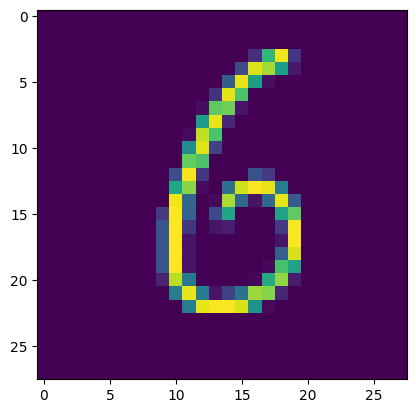

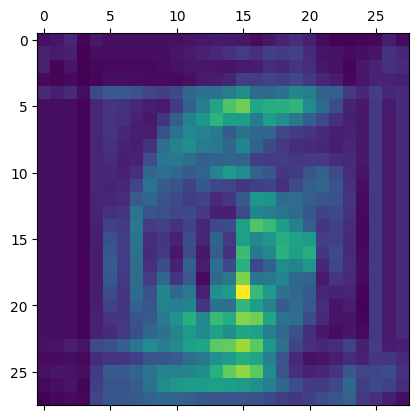

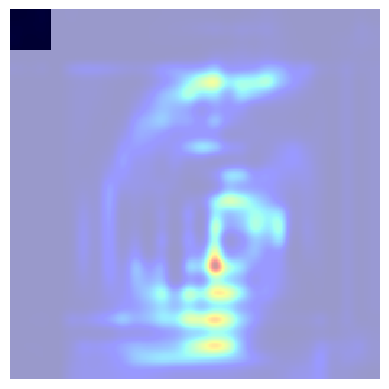

In [161]:
from PIL import Image
import matplotlib.pyplot as plt

img_tensor = mnist_train[18][0]

gradCAM(img_tensor)

# backward_hook.remove()
# forward_hook.remove()

MNIST-M

In [3]:
!git clone https://github.com/mashaan14/MNIST-M.git

Cloning into 'MNIST-M'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 19), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 1.57 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!unzip MNIST-M.zip

In [42]:
%ls

testing/  training/
